In [1]:
import sys
print(sys.version)

3.8.16 (default, Dec  7 2022, 01:12:13) 
[GCC 7.5.0]


In [2]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [3]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.layers import Flatten, add, Dense, Dropout 
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping


print("TensorFlow version:", tf.__version__)
tf.keras.backend.set_floatx('float64')

TensorFlow version: 2.9.2


In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from PIL import Image
import os
import csv
import random

import cv2
import imutils
import glob
# Make NumPy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [5]:
#Określenie ścieżek do plików
zip = '/content/drive/MyDrive/Sieci/Baza_zdjec_przeplatane_2/Baza_zdjec_przeplatane_2.zip'
nazwa_CSV = 'nowe.csv'
folder = '/content/drive/MyDrive/Sieci/Baza_zdjec_przeplatane_2/'
folder_aktorzy = '/content/drive/MyDrive/Sieci/Baza_aktorzy_przeplatane/'
aktorzy_CSV = 'aktorzy.csv'
slesh = '/'
png = '.png'

In [9]:
!unzip '/content/drive/MyDrive/Sieci/Baza_zdjec_przeplatane_2/Baza_zdjec_przeplatane_2.zip' -d '/content'

Streaming output truncated to the last 5000 lines.
  inflating: /content/20199.png      
  inflating: /content/20200.png      
  inflating: /content/20201.png      
  inflating: /content/20202.png      
  inflating: /content/20203.png      
  inflating: /content/20204.png      
  inflating: /content/20205.png      
  inflating: /content/20206.png      
  inflating: /content/20207.png      
  inflating: /content/20208.png      
  inflating: /content/20209.png      
  inflating: /content/20210.png      
  inflating: /content/20211.png      
  inflating: /content/20212.png      
  inflating: /content/20213.png      
  inflating: /content/20214.png      
  inflating: /content/20215.png      
  inflating: /content/20216.png      
  inflating: /content/20217.png      
  inflating: /content/20218.png      
  inflating: /content/20219.png      
  inflating: /content/20220.png      
  inflating: /content/20221.png      
  inflating: /content/20222.png      
  inflating: /content/20223.png      

In [6]:
def release_list(a):
    
    del a[:]
    del a

In [8]:
#Wczytanie pliku CSV do tablicy images

with open(folder+nazwa_CSV,"r") as csvfile:
    lines = csvfile.readlines()
csvfile.close()

new = []

for i in lines:
    new.append(i.split(" "))

    
value = []
for i in new[0]:
    value.append(int(i))    
    
print(len(value))

25200


In [12]:
#Wczytanie zdjęć do tablicy images
images = []
size = len(value)

for i in range(size):
    im = Image.open('/content/'+str(i)+'.png')
    arr_im = np.array(im) 
    arr_im = arr_im / 255.0
    images.append(arr_im) 
print(len(images))

25200


In [15]:
#Inicjalizacja tablic
rand_list = []
rand_list = np.zeros((len(images)), dtype=np.uint8)

x_test = []
y_test = []

x_train = []
y_train = []


#Okreslanie wielkosci zbiorów
nighty = int(len(images)*90/100)
ten = len(images) - nighty

#Losowanie zbioru testowego
for i in range(nighty):
    
    #Pierwsze losowanie wartości
    rand = random.randint(0,len(images)-1)
    
    #Sprawdzenie czy wylosowana wartość się powtarza
    while (rand_list[rand] == 1) :
        #Jeżeli tak to ponownie losuje
        rand = random.randint(0,len(images)-1)
    
    #Zapisanie zdjecia i wartości do nowej tablicy
    x_train.append(images[rand])
    y_train.append(value[rand])
    rand_list[rand] = 1

#Losowanie zbioru uczącego
for j in range(ten):
    
    #Pierwsze losowanie wartości
    rand = random.randint(0,len(images)-1)
    
    #Sprawdzenie czy wylosowana wartość się powtarza
    while (rand_list[rand] == 1) :
        #Jeżeli tak to ponownie losuje
        rand = random.randint(0,len(images)-1)
        
    #Zapisanie zdjecia i wartości do nowej tablicy
    x_test.append(images[rand])
    y_test.append(value[rand])
    rand_list[rand] = 1
    
release_list(images)
release_list(value)

In [17]:
#Sprawdzenie poprawności losowania
val_1 = 100 * sum(y_test) / (size / 2)
print("%.2f" % val_1 + '%') 


val_2 = 100 * sum(y_train) / (size / 2)
print("%.2f" % val_2 + '%') 

9.95%
90.05%


In [18]:
x_train = np.array(x_train)
x_test = np.array(x_test)

y_train = np.array(y_train)
y_test = np.array(y_test)

[[0.    0.    0.    ... 0.314 0.    0.   ]
 [0.    0.    0.    ... 0.141 0.    0.   ]
 [0.    0.    0.    ... 0.337 0.    0.   ]
 ...
 [0.    0.    0.725 ... 0.031 0.    0.   ]
 [0.    0.    0.569 ... 0.    0.    0.   ]
 [0.    0.    0.667 ... 0.    0.    0.   ]]


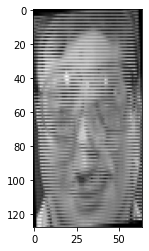

In [19]:
plt.imshow(x_train[0],cmap = 'gray')
print(x_train[0])

In [20]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(64, 128, 1)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
#model.add(Dropout(0.1))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
#model.add(Dropout(0.1))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D((2, 2)))
#model.add(Dropout(0.1))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dense(1, activation='relu'))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 126, 32)       320       
                                                                 
 batch_normalization (BatchN  (None, 62, 126, 32)      128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 63, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 61, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 29, 61, 64)       256       
 hNormalization)                                                 
                                                        

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#Funcka umożliwia zatrzymanie się uczenia 
#gdy wartość strat przstanie maleć
EarlyStop = EarlyStopping(monitor='val_loss', 
                          patience=3,
                          verbose=1)

history = model.fit(x_train, 
                    y_train, 
                    epochs=20, 
                    validation_data=(x_test, y_test),
                    callbacks = [EarlyStop]
                   )

Epoch 1/20
90/90 [==============================] - 39s 420ms/step - loss: 0.4728 - accuracy: 0.7774 - val_loss: 0.1705 - val_accuracy: 0.9264
Epoch 2/20
90/90 [==============================] - 35s 386ms/step - loss: 0.1449 - accuracy: 0.9406 - val_loss: 0.0961 - val_accuracy: 0.9542
Epoch 3/20
90/90 [==============================] - 33s 366ms/step - loss: 0.0447 - accuracy: 0.9847 - val_loss: 0.0096 - val_accuracy: 0.9958
Epoch 4/20
90/90 [==============================] - 34s 374ms/step - loss: 0.0081 - accuracy: 0.9983 - val_loss: 0.0053 - val_accuracy: 0.9986
Epoch 5/20
90/90 [==============================] - 32s 357ms/step - loss: 0.0025 - accuracy: 0.9997 - val_loss: 0.0046 - val_accuracy: 0.9972
Epoch 6/20
90/90 [==============================] - 32s 361ms/step - loss: 0.0022 - accuracy: 0.9993 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 7/20
90/90 [==============================] - 32s 353ms/step - loss: 0.0015 - accuracy: 1.0000 - val_loss: 3.8632e-04 - val_accuracy: 1.

23/23 - 2s - loss: 2.1354e-04 - accuracy: 1.0000 - 2s/epoch - 97ms/step


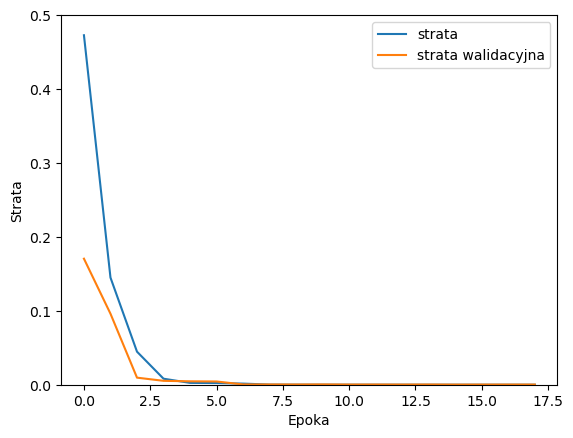

In [ ]:
plt.plot(history.history['loss'], label='strata')
plt.plot(history.history['val_loss'], label = 'strata walidacyjna')
plt.xlabel('Epoka')
plt.ylabel('Strata')
plt.ylim([0.0, 0.5])
plt.legend(loc='upper right')

test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

23/23 - 2s - loss: 2.1354e-04 - accuracy: 1.0000 - 2s/epoch - 105ms/step


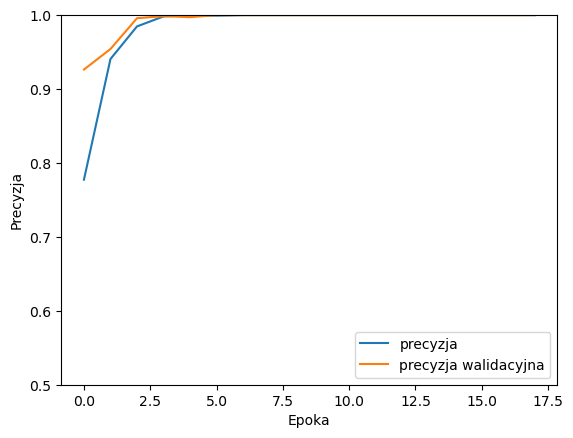

In [ ]:
plt.plot(history.history['accuracy'], label='precyzja')
plt.plot(history.history['val_accuracy'], label = 'precyzja walidacyjna')
plt.xlabel('Epoka')
plt.ylabel('Precyzja')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

In [ ]:
print(test_acc)

1.0


In [ ]:
model.evaluate(x_test,  y_test, verbose=2)

23/23 - 2s - loss: 2.1354e-04 - accuracy: 1.0000 - 2s/epoch - 93ms/step


[0.00021353744312667308, 1.0]

In [ ]:
probability_model = tf.keras.Sequential([
  model,
  tf.keras.layers.Softmax()
])

In [ ]:
arr = probability_model(x_test)

In [ ]:
ok = 0
wrong = 0
err = 0

arr_2 = []

for x in range(len(arr)):
    
    maks = 0
    for i in range(10): 
        
        if arr[x][i] > arr[x][maks]:
              maks = i
                
    if maks == 0 :
        arr_2.append(0)
        
        if maks == y_test[x] :
            ok = ok + 1          
        else:
            wrong = wrong + 1
            
            
    if maks == 1 :
        arr_2.append(1)
        if maks == y_test[x] :
            ok = ok + 1        
        else:
            wrong = wrong + 1       
    
    
    if maks > 2 :
        err = err + 1
        print(x)


print(ok) 
print(wrong) 
print(err) 
     
     

720
0
0


In [ ]:
names = [['Tn','Nn'],['Np', 'Tp']]
names = np.reshape(names,(2,2))
print(names)

tf.math.confusion_matrix(y_test,arr_2)

[['Tn' 'Nn']
 ['Np' 'Tp']]


<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[365,   0],
       [  0, 355]], dtype=int32)>